In [68]:
from torch.utils.data import Dataset
import pyedflib
import numpy as np
from scipy.signal import spectrogram, welch

In [3]:
class ChbDataset(Dataset):
    def __init__(self, data_dir='./chb-mit-scalp-eeg-database-1.0.0/',seizures_only=True,sample_rate=256):
        'Initialization'
        self.sample_rate = sample_rate
        self.data_dir = data_dir
        self.record_type = 'RECORDS-WITH-SEIZURES' if seizures_only else 'RECORDS'
                
        with open(self.data_dir+self.record_type) as f:
            self.records = f.read().strip().splitlines()
            
        with open(self.data_dir+'RECORDS-WITH-SEIZURES') as f:
            self.labelled = f.read().strip().splitlines()
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.records)
        
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        file_name = self.records[index]
        
        f = pyedflib.EdfReader(self.data_dir+file_name)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        sigbufs = np.zeros((n, f.getNSamples()[0]))
        for i in np.arange(n):
                sigbufs[i, :] = f.readSignal(i)
                
        #get labels if seizure. TODO: deal with multiple seizures
        if file_name in self.labelled:
            with open(self.data_dir + file_name.split('/')[0] + '/' + file_name.split('/')[0] + '-summary.txt') as g:
                lines = g.readlines()
                
                found = False
                i = 0
                for line in lines:
                    if file_name.split('/')[1] in line:
                        found = True
                    if found:
                        if i == 4:
                            self.seizure_start = int(line.split(' ')[3])
                        if i == 5:
                            self.seizure_end   = int(line.split(' ')[3])   
                            i = 0
                            found = False
                        i += 1

        labels = np.zeros((1, f.getNSamples()[0]))
        start  = self.sample_rate * self.seizure_start
        end    = self.sample_rate * self.seizure_end
                
        labels[:,start:end] = 1.0
        
        s     = 2 #window in seconds
        split = np.split(sigbufs,s*dataset.sample_rate,axis=1)
        labels= [np.any(ss) for ss in np.split(labels[0],s*dataset.sample_rate)]

        all_X = []
        for p_secs in split:
            p_f, p_Sxx = welch(p_secs, fs=dataset.sample_rate, axis=1)
            p_SS = np.log1p(p_Sxx)
            arr = p_SS[:] / np.max(p_SS)
            all_X.append(arr)
        
        return np.array(all_X), labels

In [4]:
dataset = ChbDataset()
item    = dataset.__getitem__(0)

In [5]:
dataset.seizure_start, dataset.seizure_end

(1467, 1494)

c:\python39\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


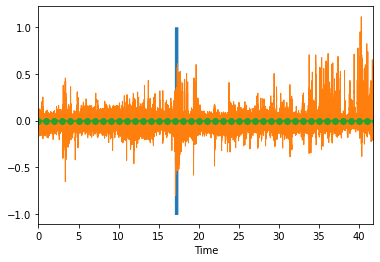

In [36]:
import matplotlib.pyplot as plt
import librosa.display as ld

sample = int(dataset.sample_rate * 10 * 60 / 1000)

#plt.plot(item[0][:,::sample])

ld.waveplot(item[2][0])
ld.waveplot(item[0]/750)

#plt.plot(item[2][:,::sample][0],'o-')
#plt.plot((np.arange(len(item[0].T)),item[0][1]))
#plt.show()